In [1]:
from scipy.spatial.transform import Rotation as R
import json
import numpy as np

def create_homogeneous_matrix(xyz, quaternion):
    rotation_matrix = R.from_quat(quaternion).as_matrix()
    T = np.eye(4) 
    T[:3, :3] = rotation_matrix
    T[:3, 3] = xyz 

    return T

def pose_inv(pose):
    R = pose[:3, :3]
    T = np.eye(4)
    T[:3, :3] = R.T
    T[:3, 3] = - R.T @ np.ascontiguousarray(pose[:3, 3])
    return T


K = np.load("handeye/intrinsics_d415.npy")
T_WC = np.load("handeye/T_WC_head.npy")
DIR = "pencile_sharpener"

with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

array([[ 4.96677473e-01,  4.12016053e-02,  4.55253290e-01,
        -9.97659431e-01,  1.90250200e-02, -6.39123210e-02,
         1.51302073e-02],
       [ 4.40391932e-01,  1.35902490e-01,  2.97994343e-01,
         9.97853233e-01, -1.53176029e-02, -6.36702943e-02,
         6.25089375e-04],
       [ 4.36594966e-01, -9.55230986e-02,  2.84233720e-01,
        -9.83311430e-01, -1.57137508e-02,  7.59195973e-03,
         1.81091334e-01],
       [ 4.40391932e-01,  5.99024898e-02,  2.97994343e-01,
         9.97853233e-01, -1.53176029e-02, -6.36702943e-02,
         6.25089375e-04]])

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def compute_pre_grasp_pose(grasp_pos, grasp_quat, approach_distance):
    # Convert quaternion to rotation matrix
    rotation = R.from_quat(grasp_quat).as_matrix()

    # Approach vector is the negative Z-axis of the end-effector in world frame
    approach_vector = -rotation[:, 2]

    # Compute the pre-grasp position
    pre_grasp_pos = grasp_pos + approach_vector * approach_distance

    # Pre-grasp orientation is the same as grasp orientation
    pre_grasp_quat = grasp_quat

    return pre_grasp_pos, pre_grasp_quat

# Given grasp pose
grasp_pos = np.array([      0.3942699968903538,
      0.10932386737208159,
      0.3461344794241349])
grasp_quat = np.array([      0.9878462476621214,
      0.0020249385540891856,
      0.041857843620528766,
      0.14967836026346082])

# Approach distance (example value)
approach_distance = 0.1

# Compute pre-grasp pose
pre_grasp_pos, pre_grasp_quat = compute_pre_grasp_pose(grasp_pos, grasp_quat, approach_distance)

# Print results
print("Pre-Grasp Position:", pre_grasp_pos)
print("Pre-Grasp Quaternion:", pre_grasp_quat)


Pre-Grasp Position: [0.38593956 0.13887876 0.44130334]
Pre-Grasp Quaternion: [0.98784625 0.00202494 0.04185784 0.14967836]


In [3]:
np.concatenate([pre_grasp_pos, pre_grasp_quat])

array([0.38593956, 0.13887876, 0.44130334, 0.98784625, 0.00202494,
       0.04185784, 0.14967836])

In [4]:
from trajectory_utils import translation_from_matrix, quaternion_from_matrix, pose_inv, \
                             project3D, create_homogeneous_matrix, apply_transformation_to_waypoints
import numpy as np

T_delta_world = np.eye(4)
live_waypoints = apply_transformation_to_waypoints(demo_waypoints[:2], T_delta_world, project3D=True)
live_waypoints

ModuleNotFoundError: No module named 'moveit_commander'

In [5]:
K1 = np.load("handeye/intrinsics_d415.npy")
K2 = np.load("handeye/intrinsics_d405.npy")

print(K1)
print(K2)

[[909.92120361   0.         646.23828125]
 [  0.         908.72631836 355.08041382]
 [  0.           0.           1.        ]]
[[431.56503296   0.         418.71490479]
 [  0.         431.18637085 235.15617371]
 [  0.           0.           1.        ]]


In [6]:
point_2Ds = []

for i in range(len(demo_waypoints)):
    point3d = pose_inv(T_WC)  @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K, point3d[:3, 3])
    
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)

point_2Ds

[array([776.06348678, 320.86510983]),
 array([855.61615526, 431.30868952]),
 array([629.87388963, 443.07371057]),
 array([762.18723527, 430.3861315 ])]

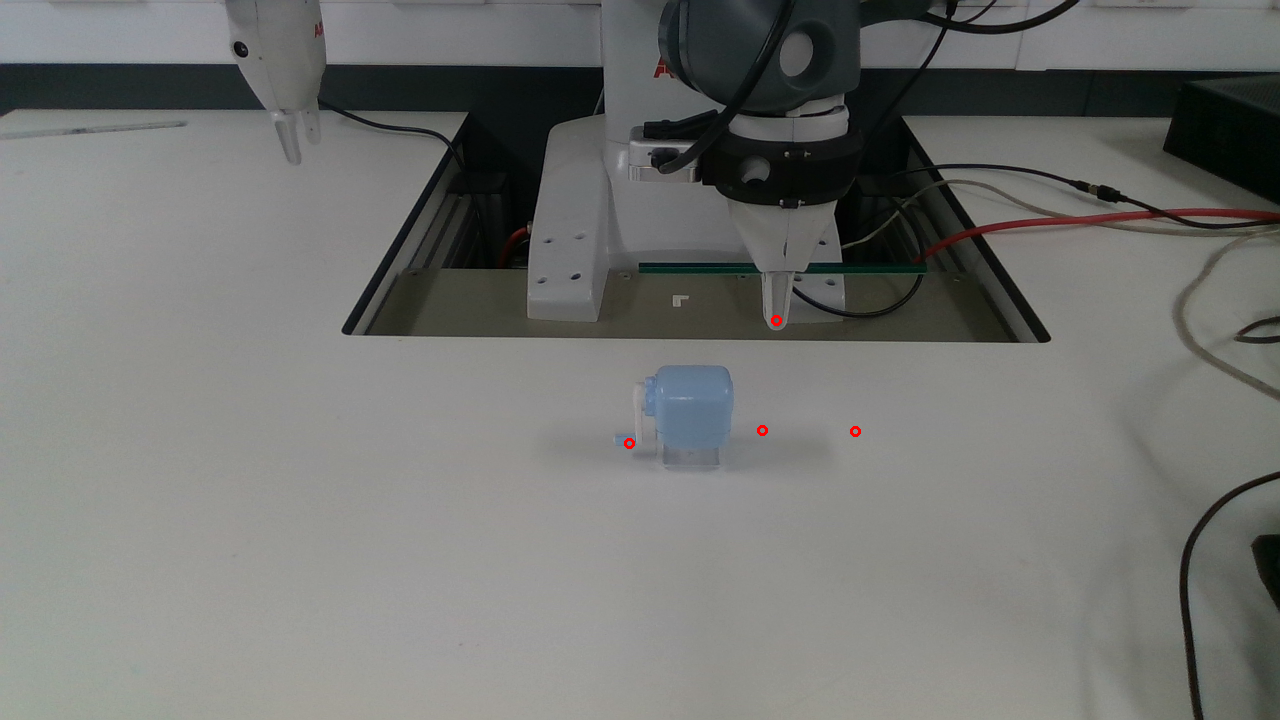

In [7]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb

In [10]:
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])

pose_inv(T_GRIP_EEF)

array([[ 1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   , -0.136],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [22]:

with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

K_wrist = np.load("handeye/intrinsics_d405.npy")
T_C_EEF = np.load("handeye/T_C_EEF_wrist_l.npy")
T_GRIP_EEF = create_homogeneous_matrix([-0.07, 0.08, 0.2], [0, 0, 0, 1])
point_2Ds = []
T_EEF_World = create_homogeneous_matrix(demo_waypoints[0, :3], demo_waypoints[0, 3:])
# T_EEF_World[2, 3] -= 0.06
for i in range(len(demo_waypoints)):

    point3d = pose_inv(T_C_EEF) @ pose_inv(T_EEF_World) @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K_wrist, point3d[:3, 3])
    print(point3d)
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)
    break

wrist_rgb = Image.open(f"experiments/{DIR}/demo_wrist_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)

print(point_2Ds)
# Save or show the image
wrist_rgb.show()

[[-0.99950681  0.02947871 -0.01082309  0.0798622 ]
 [-0.03010772 -0.99752916  0.0634752   0.00284604]
 [-0.00892518  0.06376976  0.99792473  0.16757126]
 [ 0.          0.          0.          1.        ]]
[array([624.39296354, 242.4794797 ])]


In [41]:
with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
K_wrist = np.load("handeye/intrinsics_d405.npy")

demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
m = demo_waypoints[0][:3]
m /= m[2]
p = K @ m
print(p)

# wrist_rgb = Image.open(f"experiments/{DIR}/demo_wrist_rgb.png")
# T_C_EEF = np.load("handeye/T_C_EEF_wrist_l.npy")
# draw = ImageDraw.Draw(wrist_rgb)
# x, y, r = p[0], p[1], 5
# # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
# draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)

# # Save or show the image
# wrist_rgb.show()

[1.63895459e+03 4.37322506e+02 1.00000000e+00]


In [40]:
with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
bottleneck_left= np.array(dbn['bottleneck_left'])
m = bottleneck_left[:3] / bottleneck_left[2]
m

array([1.09099151, 0.0905026 , 1.        ])

In [16]:
import numpy as np
from scipy.optimize import minimize
import cv2

def project_points(X, K, R, t):
    """ Project 3D points X to 2D points using camera intrinsics K, rotation R, and translation t. """
    X_cam = R @ X + t
    X_cam = X_cam / X_cam[2]  # Normalize by depth
    uv = K @ X_cam
    return uv[:2]

def reprojection_error(params, X_world, uv_pixel, K):
    """ Compute the reprojection error. """
    # Extract rotation vector and translation vector from params
    rvec = params[:3]
    tvec = params[3:]

    # Convert rotation vector to rotation matrix
    R, _ = cv2.Rodrigues(rvec)

    # Project points
    uv_proj = project_points(X_world, K, R, tvec)

    # Compute error
    error = uv_proj - uv_pixel
    return np.sum(error**2)



# 3D point in world coordinates (example values)
X_world = demo_waypoints[0, :3]

# Corresponding pixel coordinates in image
uv_pixel = np.array([624.39296354, 242.4794797])

# Initial guess for rotation (rvec) and translation (tvec)
initial_guess = np.zeros(6)

# Perform optimization to minimize the reprojection error
result = minimize(reprojection_error, initial_guess, args=(X_world, uv_pixel, K), method='BFGS')

# Extract optimized rotation and translation
rvec_optimized = result.x[:3]
tvec_optimized = result.x[3:]

# Convert optimized rotation vector to matrix
R_optimized, _ = cv2.Rodrigues(rvec_optimized)

print("Optimized Rotation Matrix:\n", R_optimized)
print("Optimized Translation Vector:\n", tvec_optimized)

tvec_optimized[-1] += 1

for i in range(len(demo_waypoints)):

    R, _ = cv2.Rodrigues(rvec_optimized)

    # Project points
    point_2D = project_points(X_world, K, R, tvec_optimized)

    point_2Ds.append(point_2D)
    break

wrist_rgb = Image.open(f"experiments/{DIR}/demo_wrist_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)

print(point_2Ds)
# Save or show the image
wrist_rgb.show()


Optimized Rotation Matrix:
 [[ 0.97436952  0.19521313 -0.11178494]
 [-0.20595953  0.97400567 -0.09430601]
 [ 0.09046939  0.11491207  0.98924744]]
Optimized Translation Vector:
 [-0.48022394 -0.09683016  1.12959859]
[array([624.39296802, 242.47943763]), array([625.65597636, 248.98957418]), array([629.5218778 , 268.91624089]), array([632.70035398, 285.29959581])]


In [196]:
create_homogeneous_matrix([0.58381608, -0.00932566, 0.3015399], [0, 0, 0, 1])


array([[ 1.        ,  0.        ,  0.        ,  0.58381608],
       [ 0.        ,  1.        ,  0.        , -0.00932566],
       [ 0.        ,  0.        ,  1.        ,  0.3015399 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

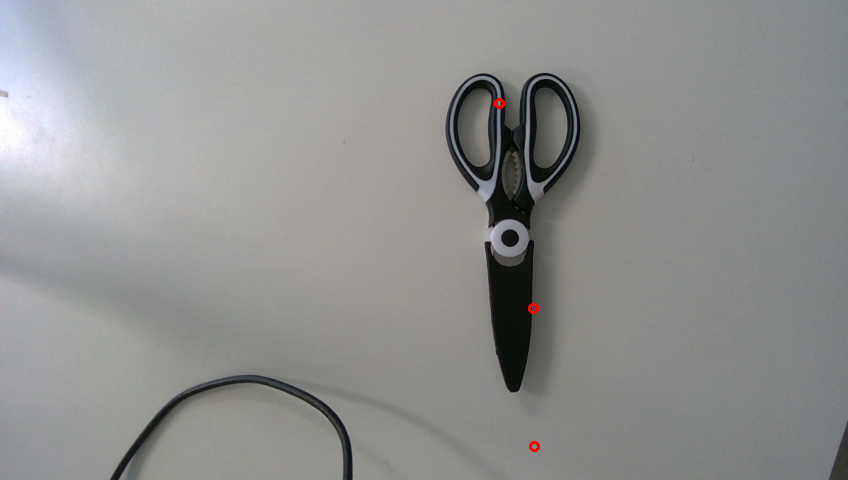

In [189]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_d405_rgb.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

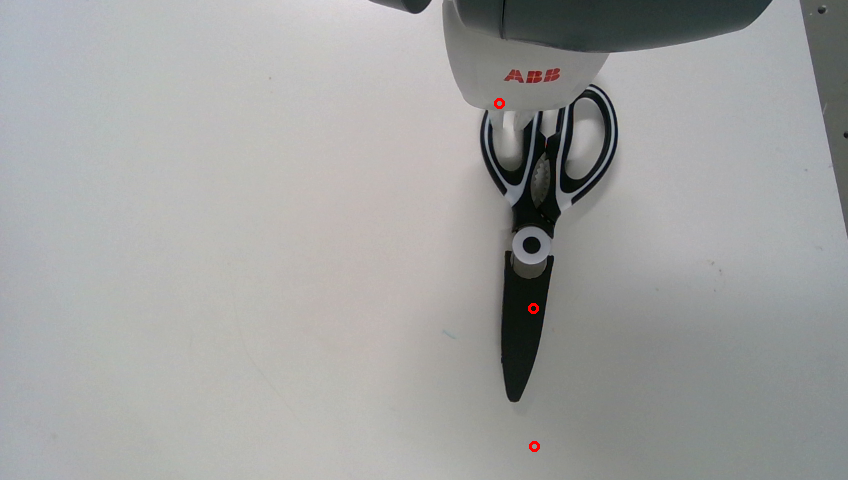

In [172]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_right_in_view.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

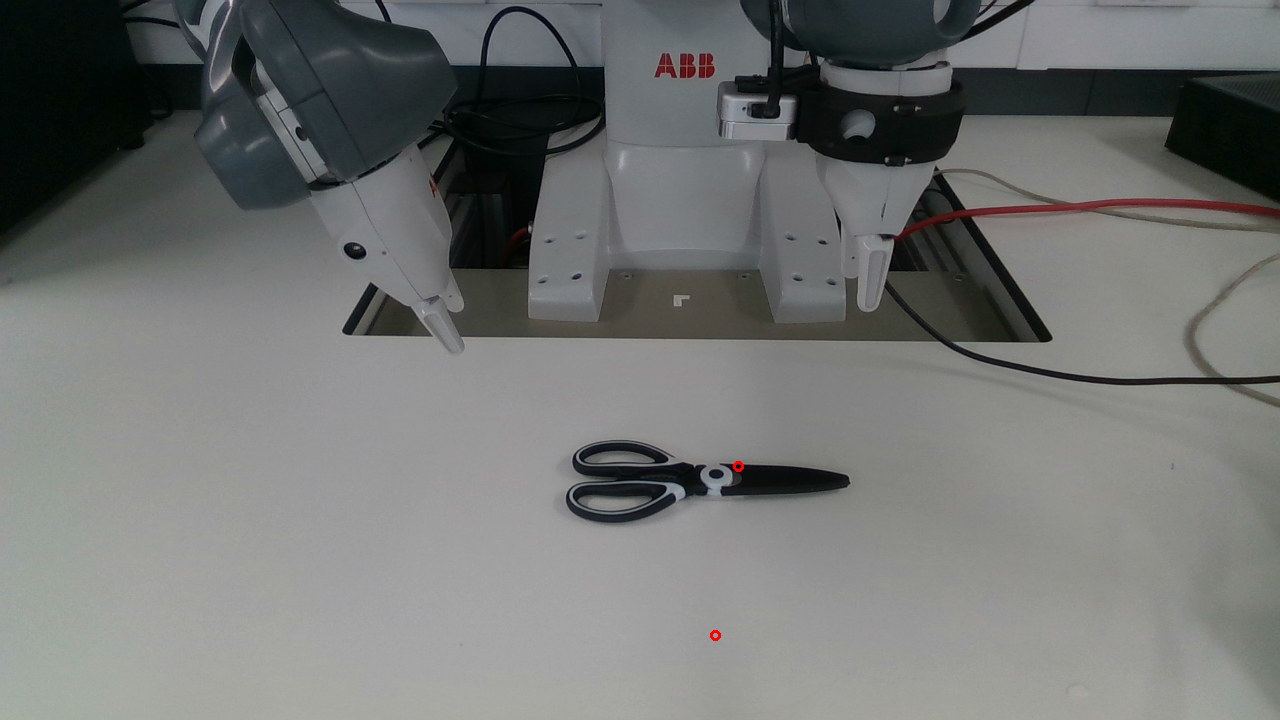

In [36]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in [[738, 466], [715, 635], [800, 910]]:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb

In [28]:
import numpy as np
import json
from scipy.spatial.transform import Rotation as R

T_C_EEF = np.load("handeye/T_C_EEF_wrist_l.npy")
T_WC = np.load("handeye/T_WC_head.npy")
with open("experiments/pencile_sharpener/demo_bottlenecks.json") as f:
    dbn = json.load(f)
T_EEF_WORLD = create_homogeneous_matrix(dbn["bottleneck_left"][:3], dbn["bottleneck_left"][3:])

T_wrist2head = pose_inv(T_WC) @ T_EEF_WORLD @ T_C_EEF
print("Ground Truth:", T_wrist2head)

def create_homogeneous_matrix(xyz, quaternion):
    # Convert the quaternion to a rotation matrix
    rotation_matrix = R.from_quat(quaternion).as_matrix()
    T = np.eye(4)  # Start with an identity matrix
    T[:3, :3] = rotation_matrix  # Insert the rotation matrix
    T[:3, 3] = xyz  # Insert the translation vector

    return T

def pose_inv(pose):
    R = pose[:3, :3]
    T = np.eye(4)
    T[:3, :3] = R.T
    T[:3, 3] = - R.T @ np.ascontiguousarray(pose[:3, 3])
    return T

T_demo_head = np.eye(4)
T_demo_head[:3, :3] = np.array([[ 0.99877238,  0.00956438, -0.04860247],
                               [-0.01090592,  0.99956471, -0.0274125 ],
                               [ 0.04831913,  0.0279089 ,  0.99844193]])
T_demo_head[:3, 3] = np.array([-0.0567, -0.0269,  0.9973])

T_demo_wrist = np.eye(4)
T_demo_wrist[:3, :3] = np.array([[-0.1367619 ,  0.70467824,  0.69622183],
                                 [-0.56060952,  0.52439082, -0.64088321],
                                 [-0.8167088 , -0.47795692,  0.32333267]])
T_demo_wrist[:3, 3] = np.array([-0.1247,  0.0156,  0.8884])

T_wrist2head = pose_inv(T_demo_wrist) @ T_demo_head 
print("Estimated:", T_wrist2head)

Ground Truth: [[ 0.00258013  0.99866399 -0.05160982  0.01079271]
 [-0.44107452  0.04745492  0.89621499 -0.10948255]
 [ 0.89746678  0.02045143  0.44060768  0.52353831]
 [ 0.          0.          0.          1.        ]]
Estimated: [[-0.1699427  -0.58446698 -0.79342164 -0.07441349]
 [ 0.67499974  0.51756312 -0.5258362  -0.026418  ]
 [ 0.71797971 -0.62492145  0.30655901  0.10979155]
 [ 0.          0.          0.          1.        ]]
